In [1]:
import time
import warnings
warnings.simplefilter('ignore')
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LinearRegression,GammaRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
import lightgbm as lgb

In [2]:
# 分析データに関する設定
# SEED = 100 #これを基本的に使用
SEED = 202120971 # #これを基本的に使用（自分の学籍番号）

## 精度一覧

In [4]:
# 1. データの読み込み
###### 633 nm ######
wavelen = 633

# 補正後のprofile特徴量
feature_First_df = pd.read_csv(f'./../data/data_FirstStorage/data_laser/feature/feature_CB/feature_texture/{wavelen}nm/feature_all.csv',index_col=0)
feature_Second_df = pd.read_csv(f'./../data/data_SecondStorage/data_laser/feature/feature_CB/feature_texture/{wavelen}nm/feature_all.csv',index_col=0)
feature_profile = pd.concat([feature_First_df, feature_Second_df],axis=0).iloc[:,:]

# 補正前の画像特徴量
feature_First_image = pd.read_csv(f'./../data/data_FirstStorage/data_laser/feature/feature_2/feature_texture/{wavelen}nm/feature_all.csv',index_col=0)
feature_Second_image = pd.read_csv(f'./../data/data_SecondStorage/data_laser/feature/feature_2/feature_texture/{wavelen}nm/feature_all.csv',index_col=0)
feature_image = pd.concat([feature_First_image, feature_Second_image],axis=0).iloc[:,62:]

# 特徴量の結合
feature_df_633 = pd.concat([feature_profile, feature_image],axis=1)
feature_df_633.columns = [f'{col}_{wavelen}' for col in feature_df_633.columns]

###### 850 nm ######
wavelen = 850

# 補正後のprofile特徴量
feature_First_df = pd.read_csv(f'./../data/data_FirstStorage/data_laser/feature/feature_CB/feature_texture/{wavelen}nm/feature_all.csv',index_col=0)
feature_Second_df = pd.read_csv(f'./../data/data_SecondStorage/data_laser/feature/feature_CB/feature_texture/{wavelen}nm/feature_all.csv',index_col=0)
feature_profile = pd.concat([feature_First_df, feature_Second_df],axis=0).iloc[:,:]

# 補正前の画像特徴量
feature_First_image = pd.read_csv(f'./../data/data_FirstStorage/data_laser/feature/feature_2/feature_texture/{wavelen}nm/feature_all.csv',index_col=0)
feature_Second_image = pd.read_csv(f'./../data/data_SecondStorage/data_laser/feature/feature_2/feature_texture/{wavelen}nm/feature_all.csv',index_col=0)
feature_image = pd.concat([feature_First_image, feature_Second_image],axis=0).iloc[:,62:]

# 特徴量の結合
feature_df_850 = pd.concat([feature_profile, feature_image],axis=1)
feature_df_850.columns = [f'{col}_{wavelen}' for col in feature_df_850.columns]


##### 目的変数 #####
target_First_df = pd.read_csv(f'./../data/data_FirstStorage/data_texture/TextureFeature/Feature_all.csv',index_col=0)
target_Second_df = pd.read_csv(f'./../data/data_SecondStorage/data_texture/TextureFeature/Feature_all.csv',index_col=0)
target_df = pd.concat([target_First_df, target_Second_df],axis=0)
target_df.index = feature_df_633.index
target_df_all = target_df.copy()

###### 合成と削除 ######
feature_df = pd.concat([feature_df_633, feature_df_850],axis=1)


target_df = target_df.dropna(axis=0)
feature_df = feature_df.reset_index()
target_df = target_df.reset_index()

target_df = target_df.drop(target_df.index[84],axis=0)
feature_df = feature_df.drop([feature_df.index[84]],axis=0)

feature_df = feature_df.drop(['index'],axis=1)
target_df.index = target_df['index']
target_df = target_df.drop(['index'],axis=1)
feature_df.index = target_df.index
target_df_all = target_df.copy()



for i_col in tqdm(target_df_all.columns.to_list()):
    
    target_df = target_df_all[i_col]
    
    X_test = feature_df[feature_df.index.str.contains('9|10')]
    X_train = feature_df.drop(X_test.index, axis=0)
    y_test = target_df[target_df.index.str.contains('9|10')]
    y_train = target_df.drop(y_test.index, axis=0)

    # 標準化
    scaler = StandardScaler()

    X_train_scale = scaler.fit_transform(X_train)
    X_train_scale = pd.DataFrame(X_train_scale,
                                 columns = X_train.columns,
                                 index = X_train.index)


    X_test_scale = scaler.transform(X_test)
    X_test_scale = pd.DataFrame(X_test_scale,
                                 columns = X_test.columns,
                                 index = X_test.index)
    
    THRESH = 0.1
    temp = abs(pd.concat([X_train_scale,y_train],axis=1).corr())[i_col][abs(pd.concat([X_train_scale, y_train],axis=1).corr())[i_col].sort_values(ascending=False)>THRESH].index
    temp = temp.drop([i_col])


    X_train_scale = X_train_scale.loc[:,temp]
    X_test_scale = X_test_scale.loc[:,temp]
    
    

    ##### パラメータの設定 #####
    kf_inner = KFold(n_splits=10, shuffle=True, random_state=SEED)
    
    # PLS
    param_pls = {'n_components':[i for i in range(6,15)]}

    # SVM
    param_svm = {
        'C':[2*i for i in range(1,50)], 
        'kernel':['rbf'],
        'gamma':[1e-1,5e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5]
        # 200,150,100,50,10,5,1,
    }

    param_ann = {'hidden_layer_sizes':[(100,),(70,),(30,)],#3*i for i in range(1,21)
                 'activation':['relu'],
                 'solver':['adam'],
                 'alpha':[500,200,100],
                 'batch_size':[50,100],
                }

    # RandomForest
    param_ranfo = {
        "n_estimators": [10*i for i in range(20)],
        "max_depth":[10,15,20,25,30],
        "max_features": ["sqrt"],
        "min_samples_leaf":[i for i in range(2,5)]
    }

    ##### GridSearch #####
    # PLSのGridSearch 
    CV_pls = GridSearchCV(
        PLSRegression(),
        param_pls,
        cv=kf_inner,
        n_jobs = -1
    )
    # SVMのGridSearch
    CV_svm = GridSearchCV(
        SVR(),
        param_svm,
        cv=kf_inner,
        n_jobs=-1
    )
    # RandomForestのGridSearch
    CV_ranfo = GridSearchCV(
        RandomForestRegressor(n_jobs=-1,random_state=SEED),
        param_ranfo,
        cv=kf_inner,
        n_jobs=-1
    )
    # ANNのGridSearch
    CV_ann = GridSearchCV(
        MLPRegressor(early_stopping=True,random_state=SEED),
        param_ann,
        cv=kf_inner,
        n_jobs=-1
    )


    # GridSearchの結果表示
    results_pls = CV_pls.fit(X_train_scale, y_train)
    results_svm = CV_svm.fit(X_train_scale,y_train.values.ravel())
    results_ranfo = CV_ranfo.fit(X_train_scale,y_train.values.ravel())
    results_ann = CV_ann.fit(X_train_scale.values,y_train.values.ravel())

    ###### 指定したハイパラでモデル構築 #####

    # PLS
    pls = PLSRegression(n_components=results_pls.best_params_['n_components'])
    model_PLS = pls.fit(X_train_scale,y_train)

    # SVM
    svm = SVR(
        kernel='rbf',
        C=results_svm.best_params_['C'], 
        gamma=results_svm.best_params_['gamma']
    )
    model_SVM = svm.fit(X_train_scale, y_train)

    # RandomForest
    ranfo = RandomForestRegressor(n_estimators=results_ranfo.best_params_['n_estimators'],
                                  max_depth=results_ranfo.best_params_['max_depth'],
                                  n_jobs=-1,
                                  random_state=SEED)
    model_RNF = ranfo.fit(X_train_scale, y_train)

    # ANN
    ann = MLPRegressor(hidden_layer_sizes=results_ann.best_params_['hidden_layer_sizes'],
                       activation=results_ann.best_params_['activation'],
                       solver=results_ann.best_params_['solver'],
                       alpha=results_ann.best_params_['alpha'],
                       batch_size=results_ann.best_params_['batch_size'],
                       random_state=SEED
                      )

    model_ANN = ann.fit(X_train_scale, y_train)


    ##### モデルの予測 #####

    # trainの予測
    y_pred_train_ANN = model_ANN.predict(X_train_scale).flatten()
    y_pred_train_SVM = model_SVM.predict(X_train_scale).flatten()
    y_pred_train_PLS = model_PLS.predict(X_train_scale).flatten()
    y_pred_train_RNF = model_RNF.predict(X_train_scale).flatten()

    y_pred_train_SVM_PLS = np.mean([y_pred_train_SVM,y_pred_train_PLS],axis=0)
    y_pred_train_ANN_SVM = np.mean([y_pred_train_ANN,y_pred_train_SVM],axis=0)
    y_pred_train_ANN_PLS = np.mean([y_pred_train_ANN,y_pred_train_PLS],axis=0)
    y_pred_train_ANN_SVM_PLS = np.mean([y_pred_train_ANN,y_pred_train_SVM, y_pred_train_PLS],axis=0)


    # testの予測
    y_pred_SVM = model_SVM.predict(X_test_scale).flatten()
    y_pred_PLS = model_PLS.predict(X_test_scale).flatten()
    y_pred_ANN = model_ANN.predict(X_test_scale).flatten()
    y_pred_RNF = model_RNF.predict(X_test_scale).flatten()

    y_pred_SVM_PLS = np.mean([y_pred_SVM,y_pred_PLS.flatten()],axis=0)
    y_pred_ANN_SVM = np.mean([y_pred_ANN,y_pred_SVM],axis=0)
    y_pred_ANN_PLS = np.mean([y_pred_ANN,y_pred_PLS],axis=0)
    y_pred_ANN_SVM_PLS = np.mean([y_pred_ANN,y_pred_SVM_PLS],axis=0)

    # weight averaging
    # weightを求める
    model_list = [model_PLS,model_SVM,model_ANN]
    i_weight_sum = 0
    i_weight_list = []
    for i_model in model_list:
        i_model_pred = i_model.predict(X_train_scale).flatten()
        i_weight = 1/np.sqrt(mean_squared_error(y_train.values.flatten(),i_model_pred.flatten())) # errorの逆数
        i_weight_list.append(i_weight)
        i_weight_sum += i_weight

    i_weight_array = np.array(i_weight_list)/i_weight_sum

    y_pred_train_weight_3 = np.average([y_pred_train_ANN,y_pred_train_SVM, y_pred_train_PLS],weights=i_weight_array,axis=0)
    y_pred_weight_3 = np.average([y_pred_ANN,y_pred_SVM, y_pred_PLS],weights=i_weight_array,axis=0)
    
    
    
    ##### Stacking #####

    X_ensemble_train = pd.concat([
              pd.DataFrame(y_pred_train_PLS,columns=['PLS'],index=y_train.index),
              pd.DataFrame(y_pred_train_SVM,columns=['SVM'],index=y_train.index),
              pd.DataFrame(y_pred_train_RNF,columns=['RNF'],index=y_train.index),
              pd.DataFrame(y_pred_train_ANN,columns=['ANN'],index=y_train.index)
              ],axis=1
             )

    X_ensemble_test = pd.concat([
              pd.DataFrame(y_pred_PLS,columns=['PLS'],index=y_test.index),
              pd.DataFrame(y_pred_SVM,columns=['SVM'],index=y_test.index),
              pd.DataFrame(y_pred_RNF,columns=['RNF'],index=y_test.index),
              pd.DataFrame(y_pred_ANN,columns=['ANN'],index=y_test.index),
              ],axis=1
             )

    # stacking (regression model : SVM)
    param_svm = {
        'C':[5*i for i in range(1,100)], 
        'kernel':['rbf'],
        'gamma':[1e-1,5e-1,1e-2,5e-2,1e-3,5e-3,1e-4,5e-4,1e-5,5e-5,1e-6,5e-6]
        # 200,150,100,50,10,5,1,
    }

    # Stacking(ANNのGridSearch)
    CV_svm_stacking = GridSearchCV(
        SVR(),
        param_svm,
        cv=kf_inner,
        n_jobs=-1
    )

    results_svm_stack = CV_svm_stacking.fit(X_ensemble_train.values,y_train.values.ravel())

    svm = SVR(C=results_svm_stack.best_params_['C'],
                       kernel=results_svm_stack.best_params_['kernel'],
                       gamma=results_svm_stack.best_params_['gamma'],
                       # alpha=results_ann_stack.best_params_['alpha'],
                       # batch_size=results_ann_stack.best_params_['batch_size'],
                       # random_state=SEED
                      )

    model_SVM = svm.fit(X_ensemble_train.values, y_train.values.ravel())

    y_pred_train_stack = model_SVM.predict(X_ensemble_train)
    y_pred_stack = model_SVM.predict(X_ensemble_test)
    
    
    ###############
    # ５. 精度評価
    RANGE = np.max(y_test) - np.min(y_test)

    temp = pd.DataFrame([
        [
            np.corrcoef(y_train.values.flatten(),y_pred_train_SVM)[0][1], 
            np.corrcoef(y_train.values.flatten(),y_pred_train_PLS.flatten())[0][1],
            np.corrcoef(y_train.values.flatten(),y_pred_train_ANN.flatten())[0][1],
            np.corrcoef(y_train.values.flatten(),y_pred_train_ANN_SVM_PLS.flatten())[0][1],
            np.corrcoef(y_train.values.flatten(),y_pred_train_weight_3.flatten())[0][1],
            np.corrcoef(y_train.values.flatten(),y_pred_train_stack.flatten())[0][1],
        ],

        [
            np.corrcoef(y_test.values.flatten(),y_pred_SVM)[0][1],
            np.corrcoef(y_test.values.flatten(),y_pred_PLS.flatten())[0][1],
            np.corrcoef(y_test.values.flatten(),y_pred_ANN.flatten())[0][1],
            np.corrcoef(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten())[0][1],
            np.corrcoef(y_test.values.flatten(),y_pred_weight_3.flatten())[0][1],
            np.corrcoef(y_test.values.flatten(),y_pred_stack.flatten())[0][1]
        ],

        [
            np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_SVM)),
            np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_PLS.flatten())),
            np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_ANN.flatten())),
            np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_ANN_SVM_PLS.flatten())),
            np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_weight_3.flatten())),
            np.sqrt(mean_squared_error(y_train.values.flatten(),y_pred_train_stack.flatten())),
        ],

        [
            np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_SVM)),
            np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_PLS.flatten())),
            np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN.flatten())),
            np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten())),
            np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_weight_3.flatten())),
            np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_stack.flatten()))
        ],

        [
            np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_SVM.flatten())[0][1]**2)),
            np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_PLS.flatten())[0][1]**2)),
            np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_ANN.flatten())[0][1]**2)),
            np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten())[0][1]**2)),
            np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_weight_3.flatten())[0][1]**2)),
            np.sqrt(1/(1 - np.corrcoef(y_test.values.flatten(),y_pred_stack.flatten())[0][1]**2))
        ],
        
        [
            RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_SVM)),
            RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_PLS.flatten())),
            RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN.flatten())),
            RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten())),
            RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_weight_3.flatten())),
            RANGE/np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_stack.flatten()))
        ],
        
        [
            100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_SVM))/RANGE,
            100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_PLS.flatten()))/RANGE,
            100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN.flatten()))/RANGE,
            100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_ANN_SVM_PLS.flatten()))/RANGE,
            100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_weight_3.flatten()))/RANGE,
            100*2*np.sqrt(mean_squared_error(y_test.values.flatten(),y_pred_stack.flatten()))/RANGE
        ],
    ])

    temp.columns = ['SVM','PLS','ANN','Simple Ensemble','Weighted Ensemble','Stacking(SVM)']
    temp.index = ['R_train','R_test','RMSE_train','RMSE_test','RPD_test','RER_test','EI_test']
    temp = temp.T

    # 保存
    i_col = i_col[:7]
    temp.to_csv(f'./../output/表_精度一覧_texture_{i_col}.csv')
    

  0%|          | 0/8 [00:00<?, ?it/s]/Users/daiki/python_enviroment/MasterDegree/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/daiki/python_enviroment/MasterDegree/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/daiki/python_enviroment/MasterDegree/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/daiki/python_enviroment/MasterDegree/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stocha

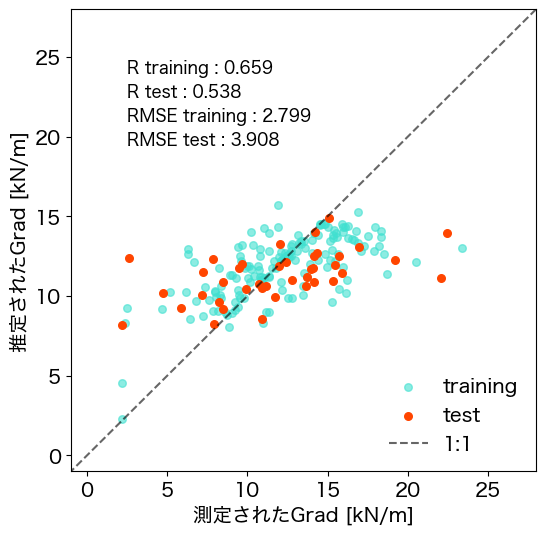

In [5]:
fig = plt.figure(figsize=(6,6))
# plt.scatter(y_train,y_pred_train_SVM,c='turquoise',alpha=0.6,label='training',marker='.',s=120)
# plt.scatter(y_test,y_pred_SVM,c='orangered',alpha=1,label='test',marker='.',s=120)

plt.scatter(y_train,y_pred_train_SVM,c='turquoise',alpha=0.6,label='training',marker='.',s=120)
plt.scatter(y_test,y_pred_SVM,c='orangered',alpha=1,label='test',marker='.',s=120)

plt.plot([-100,100],[-100,100],c='k',linestyle='dashed',label='1:1',alpha=0.6)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('測定されたGrad [kN/m]',fontsize=14)
plt.ylabel('推定されたGrad [kN/m]',fontsize=14)

MODEL = 'SVM'

plt.text(2.5,24,f"R training : {temp.T[MODEL][0]:.3f}",fontsize=12)
plt.text(2.5,22.5,f"R test : {temp.T[MODEL][1]:.3f}",fontsize=12)
plt.text(2.5,21,f"RMSE training : {temp.T[MODEL][2]:.3f}",fontsize=12)
plt.text(2.5,19.5,f"RMSE test : {temp.T[MODEL][3]:.3f}",fontsize=12)
plt.xlim(int(target_df.min())-3,int(target_df.max())+5)
plt.ylim(int(target_df.min())-3,int(target_df.max())+5)

# plt.text(0.7,1.35,f"R training : {temp.T[MODEL][0]:.3f}",fontsize=12)
# plt.text(0.7,1.3,f"R test : {temp.T[MODEL][1]:.3f}",fontsize=12)
# plt.text(0.7,1.25,f"RMSE training : {temp.T[MODEL][2]:.3f}",fontsize=12)
# plt.text(0.7,1.2,f"RMSE test : {temp.T[MODEL][3]:.3f}",fontsize=12)
# plt.xlim(target_df.min()-0.1,target_df.max()+0.1)
# plt.ylim(target_df.min()-0.1,target_df.max()+0.1)

plt.legend(loc='lower right', fontsize=14, frameon=False)

plt.xlim(int(target_df.min())-3,int(target_df.max())+5)
plt.ylim(int(target_df.min())-3,int(target_df.max())+5)

plt.show()


fig.savefig(f'./../output/図_texture_yyplot.png',dpi=400)